# Anomaly Detection - Zelong
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>

**Dennis Milechin, Ivan Sunyagin, Hany Bassily**

## Hurricane Detection


Import libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import time
from scipy.integrate import simps

import pydotplus
from IPython import display
from IPython.display import Image
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
sns.set_palette("RdBu", n_colors=32)
from inspect import getmembers

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors

from scipy import stats
from scipy.stats import gaussian_kde as PDF

import collections
from matplotlib import rcParams
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


**---**

## 1.0 Open a datasets

In [5]:
# Open data sets:
# --------------

# Number of files
f = 10

# Data dictionary
data_dic = {}

# specify date columns
date_range = [[0,1,2,3,4]]

# Create a date parser
dateparse = lambda x: pd.datetime.strptime(x, '%Y %m %d %H %M')

# Open the data files
for i in range(f):
    file_name = 'datasets/42058/42058' + str(i+1) + '2016.txt'
    inter = pd.read_csv(file_name , delim_whitespace = True , skiprows = [1],
                                              parse_dates = {'DATETIME' : [0,1,2,3,4] },
                                             date_parser=dateparse)
    data_dic['df_' + str(i + 1)] = inter
    

# Sanity check    
data_dic['df_1'].head(10)

,DATETIME,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,2015-12-31 23:50:00,75,11.9,16.4,3.67,9.09,7.12,91,1012.1,27.7,27.3,24.0,99.0,99.0
1,2016-01-01 00:50:00,71,13.4,16.7,3.26,9.09,6.74,93,1012.6,27.6,27.3,23.9,99.0,99.0
2,2016-01-01 01:50:00,73,11.7,14.2,3.35,8.33,6.74,110,1013.0,27.6,27.4,24.1,99.0,99.0
3,2016-01-01 02:50:00,79,12.5,15.2,3.61,9.09,7.01,92,1013.2,27.5,27.4,23.8,99.0,99.0
4,2016-01-01 03:50:00,82,11.5,16.0,3.41,8.33,6.80,95,1013.3,27.3,27.4,23.9,99.0,99.0
5,2016-01-01 04:50:00,77,12.6,15.8,3.60,9.09,7.08,98,1012.7,27.3,27.4,23.7,99.0,99.0
6,2016-01-01 05:50:00,80,11.9,14.4,3.61,9.09,6.97,103,1012.2,27.5,27.4,23.8,99.0,99.0
7,2016-01-01 06:50:00,78,11.9,14.8,3.82,9.09,7.32,98,1011.5,27.3,27.5,23.8,99.0,99.0
8,2016-01-01 07:50:00,78,12.0,15.9,3.70,9.09,7.11,108,1010.9,27.4,27.5,23.7,99.0,99.0
9,2016-01-01 08:50:00,79,12.2,15.7,3.69,9.09,7.09,100,1010.9,27.4,27.5,23.7,99.0,99.0


### 1.1 Concate Files

In [6]:
# Concatenate all files:
# ---------------------

# initiation
df_global_raw = data_dic['df_1']

# concatente

title = ['WSPD' , 'GST' , 'PRES' , 'ATMP']

for i in range(2,f + 1):
    df_global_raw = pd.concat([df_global_raw , data_dic['df_' + str(i)]] , axis = 0)
    
df_global = df_global_raw[title]

# data array
data_raw = df_global.values

### 1.2 Remove Defective Rows.

In [7]:
# Preprocessing
# -------------

# determine defected rows
defect = []

# itterrate
for i in range (data_raw.shape[0]):
    if data_raw[i,-1] > 200.:
        defect.append(i)

# remove rows
data_clean = np.delete(data_raw, defect, axis = 0)

## 2.0 General Functions

<br>

### 2.1- Power Martingale with defined Epsilon

<br>

In [13]:
# Function to calculate Power Martingale - Single:
# ----------------------------------------------

def power_martingale(data , eps , delay):
    
    # Normalization
    data_norm = data / np.std(data, axis = 0)
    
    # initiate Filtered data
    d = np.zeros(data_norm.shape)
    
    # delay-Filter
    for i in range (delay, data_norm.shape[0]):
        d[i, :] = data_norm[i,:] - data_norm[ i - delay , : ]
 
    # data mean
    mean = np.average(d , axis = 0)
    
    # mean vector norm
    mean_norm = np.linalg.norm(mean)

    # strangenes reference
    ref_alpha = np.linalg.norm(d.std(axis = 0)) + mean_norm

    # Length of data
    L = d.shape[0]

    # alpha
    alpha = np.linalg.norm(d , axis = 1) / ref_alpha

    # p-value(randomised)
    p_value = np.ones(alpha.shape)

    # iterrate for p-value calculation
    for i in range(1,L):
    
        # end value
        end = alpha[i]
    
        # alpha subset
        alpha_sub = alpha[:i + 1]

        # number of elements
        n = i + 1   
    
        # p-values calculation
        np.random.seed(200)
        p_value[i] = ( float(np.sum(alpha_sub > end)) + np.random.uniform() * np.sum(alpha_sub == end ) ) / float(n)
        # p_value[i] = float(np.sum(alpha_sub >= end))  / float(n)
    
        # to avoid log zero
        p_value[p_value==0] = 0.0000000001
    
    # initiate Power Martingale
    power_mart = np.zeros(alpha.shape)

    # dummy multiplier
    M = 0.
    
    # initiate difference measure
    diff_arr = np.zeros((L,))
    
    # Initiate difference multiplier
    diff = 1.

    # iterrate for power martingale calculation
    for i in range(L):
        
        # increment
        delta = eps * (p_value[i]) ** (eps - 1.)
        
        # Calculate martingale difference
        # diff_arr[i] = np.log( np.absolute(diff * (delta - 1.)) )
        diff_arr[i] = np.absolute(np.log(delta))
        
        # Update power martingal
        M += np.log(delta)  
        
        # Array
        power_mart[i] = M
        
    return power_mart , diff_arr

### 2.2- Power Martingale with Mixture

<br>

In [14]:
# Function to calculate Power Martingale:
# ---------------------------------------
# power_martingale_mix function
# Description: Calculates Power Martingale with mixture
# Input:
#       data - numpy matrix containing the data set
#       rres - Resolution of the uniform distribution for integrating epsilon values.
#       delay - 
# Return:
#       datpower_mart - Power Martingale Value
#       diff_arr - Power Martingale Value Difference
#
def power_martingale_mix(data , res , delay):
    
    # Normalization
    data_norm = data / np.std(data, axis = 0)
    
    # initiate Filtered data
    d = np.zeros(data_norm.shape)
    
    # delay-Filter
    for i in range (delay, data_norm.shape[0]):
        d[i, :] = data_norm[i,:] - data_norm[ i - delay , : ]
    

    # epsilon array
    eps = np.linspace(0.001, 0.999, res)
    
    # data mean
    mean = np.average(d , axis = 0)
    
    # mean vector norm
    mean_norm = np.linalg.norm(mean)

    # strangenes reference
    ref_alpha = np.linalg.norm(d.std(axis = 0)) + mean_norm

    # Length of data
    L = d.shape[0]

    # alpha
    alpha = np.linalg.norm(d , axis = 1) / ref_alpha

    # p-value(randomised)
    p_value = np.ones(alpha.shape)

    # iterrate for p-value calculation
    for i in range(1,L):
    
        # end value
        end = alpha[i]
    
        # alpha subset
        alpha_sub = alpha[:i - 1]

        # number of elements
        n = i + 1   
    
        # p-values calculation
        np.random.seed(200)
        p_value[i] = ( float(np.sum(alpha_sub > end)) + np.random.uniform() * np.sum(alpha_sub == end ) ) / float(n)
        # p_value[i] = float(np.sum(alpha_sub >= end))  / float(n)
    
        # to avoid log zero
        p_value[p_value==0] = 0.00000000001
    
    # initiate Power Martingale
    power_mart = np.zeros(alpha.shape)
    
    # initiate difference
    diff_arr = np.zeros(alpha.shape)

    # dummy multiplier
    M = 0.

    # iterrate for power martingale calculation
    for i in range(L):
    
        # Calculate delta Array    
        delta = np.log(eps) + (eps - 1.) * np.log(p_value[i])
        
        # Integrate for mix
        delta_mix = simps(delta , eps)
        
        # update power martingale
        M += delta_mix
        
        # Array
        power_mart[i] = M
        
        # difference
        diff_arr[i] = np.absolute(delta_mix)
        
        
    return power_mart , diff_arr

### 2.3- Support Functions

<br>

In [15]:
# Exponential Smoother:
# ---------------------
# smooth function
# Description: Exponential Smoother
# Input:
#       y - Data to be smoothed
#       alpha - alpha parameter
# Return:
#       x - smoothed values
def smooth(y , alpha):
    
    # initiation of the filtered signal array
    x = np.zeros(y.shape)
    
    # Data size
    L = y.shape[0]
    
    # intiation
    x[0] = 0.5 * (1. + alpha) * y[0]
    
    # Iterrate for new samples
    for i in range(1,L):
        x[i] = alpha * y[i] + (1. - alpha) * x[i - 1]
        
    return x

In [16]:
# Function to generate a heatmap array for raw and smoothed signal
# ----------------------------------------------------------------
# heatmap_fil function
# Description: Exponential Smoother
# Input:
#       x - Data 
#       alpha - alpha parameter
# Return:
#       x - smoothed values
def heatmap_fil(x , alpha):
    
    # signal length
    L = x.shape[0]
    
    # apply smoothing
    xk = smooth(x , alpha)
    
    # reshape arrays
    x1 = xk.reshape((1,L)) / np.max(xk)
    x2 = x.reshape((1,L)) / np.max(x)
    
    # Augment arrays
    big1 = np.concatenate((x1 , x1) , axis = 0)
    big2 = np.concatenate((x2 , x2) , axis = 0)
    
    # Join arrays
    big = np.concatenate((big1 , big2) , axis = 0)
    
    return big
        


In [22]:
# get_name function
# Description: Gets the acronym definition of a column
# Input:
#       acronym - acronym value 
# Return:
#       str - acronym name
def get_name(acronym):
    values = {
     'WDIR' : 'Wind Direction',
     'WSPD' : 'Wind Speed',
     'GST' : 'Gust Speed',
     'WVHT' : 'Wave Height',
     'DPD' : 'Dominant Wave Period',
     'APD' : 'Average Wave Period',
     'MWD' : 'DPD Direction',
     'PRES' : 'Sea Level Pressure',
     'ATMP' : 'Air Temperature',
     'WTMP' : 'Sea Surface Temperature',
     'DEWP' : 'Dewpoint Temperature',
     'VIS' : 'Station Visibility',
     'TIDE' : 'Water Level'
    }
    return values[acronym]

## 3.0 Evaluation of Models

<br>

### 3.1- General Constants

<br>

In [11]:
# Selected epsilon array
e_array = np.linspace(0.01,0.99,100)

# selected delay array
delay_array = np.array(range(1,501))

# Dimensions
rows = len(delay_array)
cols = len(e_array)

# Resolution for mixture integral
resolution = 200

# Smoothing factor for change detection
a = 0.01

# Data size
L = data_clean.shape[0]

# Epsilon Value
eps = 0.307

# Delay Value
delay = 189

# Color map 
clr = plt.get_cmap('jet')

### 3.2- Model Evaluation


In [17]:
# Model Application
# -----------------

# Power Martingale
p_mar_pwr, diff_pwr = power_martingale(data_clean,eps , delay)

# Mixture Martingale
p_mar_mix, diff_mix = power_martingale_mix(data_clean,resolution , delay)

##

### 3.3- Visualization


In [18]:
# Preprocess the data with normalization and applying best delay difference:
# --------------------------------------------------------------------------

# Select best delay to apply
best_de = delay

# Normalization
data_preproc = data_clean / np.std(data_clean, axis = 0)
    
# initiate Filtered data
data_preproc_filtered = np.zeros(data_preproc.shape)
    
# delay-Filter
for i in range (best_de, data_preproc.shape[0]):
    data_preproc_filtered[i, :] = data_preproc[i,:] - data_preproc[ i - best_de , : ]

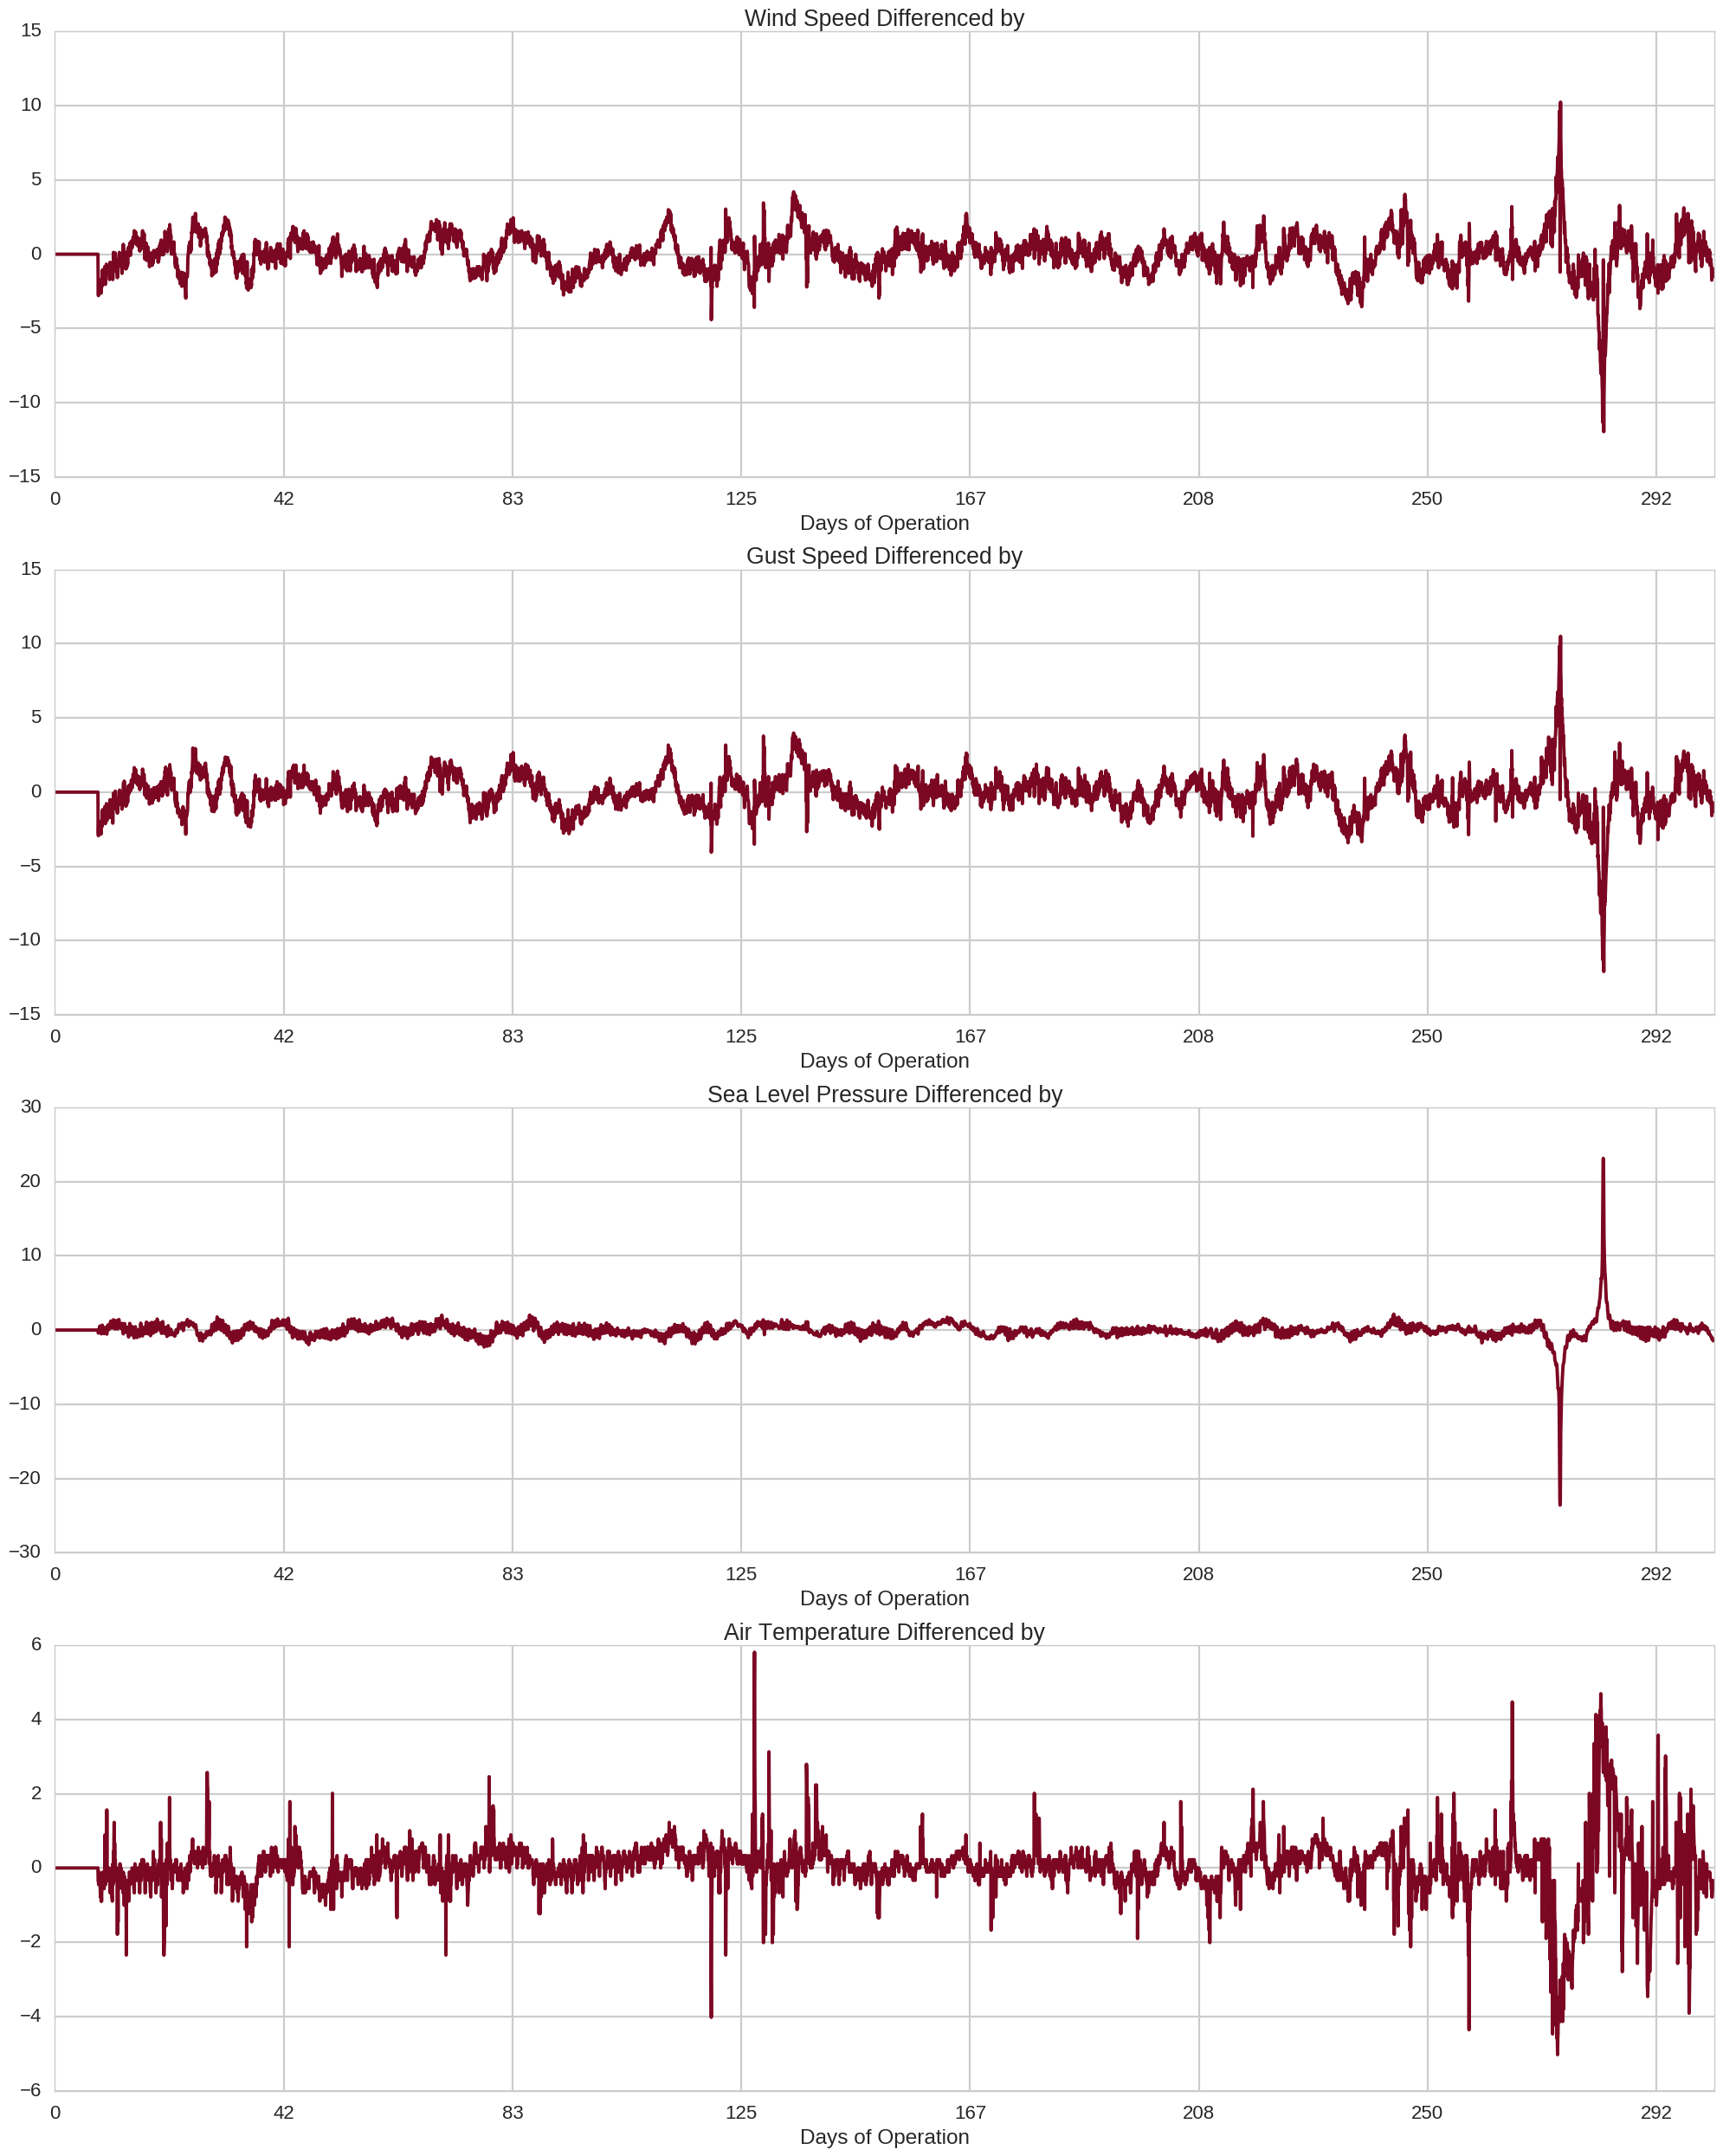

In [23]:
# Visualize the preprocessed data:
# --------------------------------

fig = plt.figure(figsize = (20, 25))
n = data_preproc_filtered.shape[1]

# iterrate for data columns
for i in range (n):
    ax = fig.add_subplot(n,1,i + 1)
    ax.plot(data_preproc_filtered[:,i])
    ax.set_title(get_name(title[i]) + ' Differenced by')
    ax.set_xlim(0, L)
    vals = ax.get_xticks()
    ax.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
    ax.set_xlabel('Days of Operation')
plt.tight_layout()
plt.show()

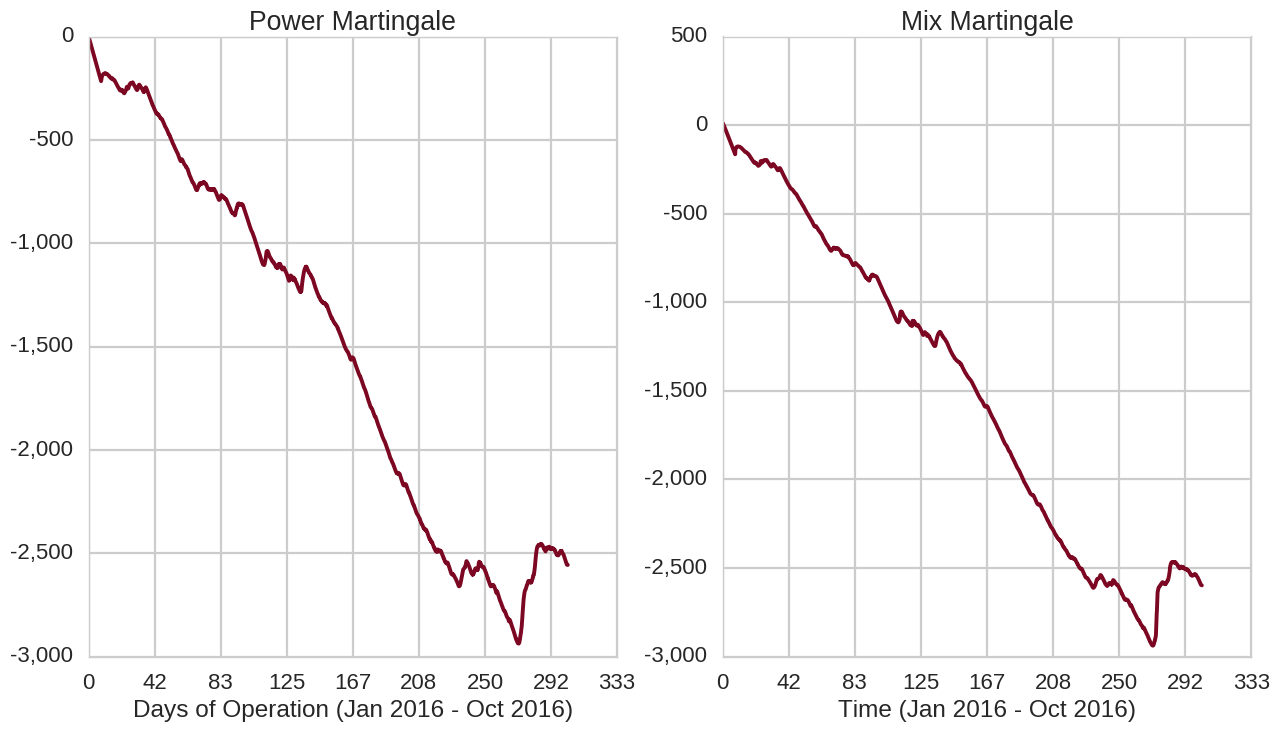

In [28]:
# Visualization of Power Martingale
# ---------------------------------

# plot initialization
fig = plt.figure(figsize = (15,8))

# plot simulated data
ax1 = fig.add_subplot(1,2,1)
ax1.plot(p_mar_pwr)
ax1.set_title('Power Martingale')
ax1.set_xlabel('Days of Operation (Jan 2016 - Oct 2016)')
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


# plot raw data
ax2 = fig.add_subplot(1,2,2)
ax2.plot(p_mar_mix)
ax2.set_title('Mix Martingale')
ax2.set_xlabel('Time (Jan 2016 - Oct 2016)')
vals = ax2.get_xticks()
ax2.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

plt.show()

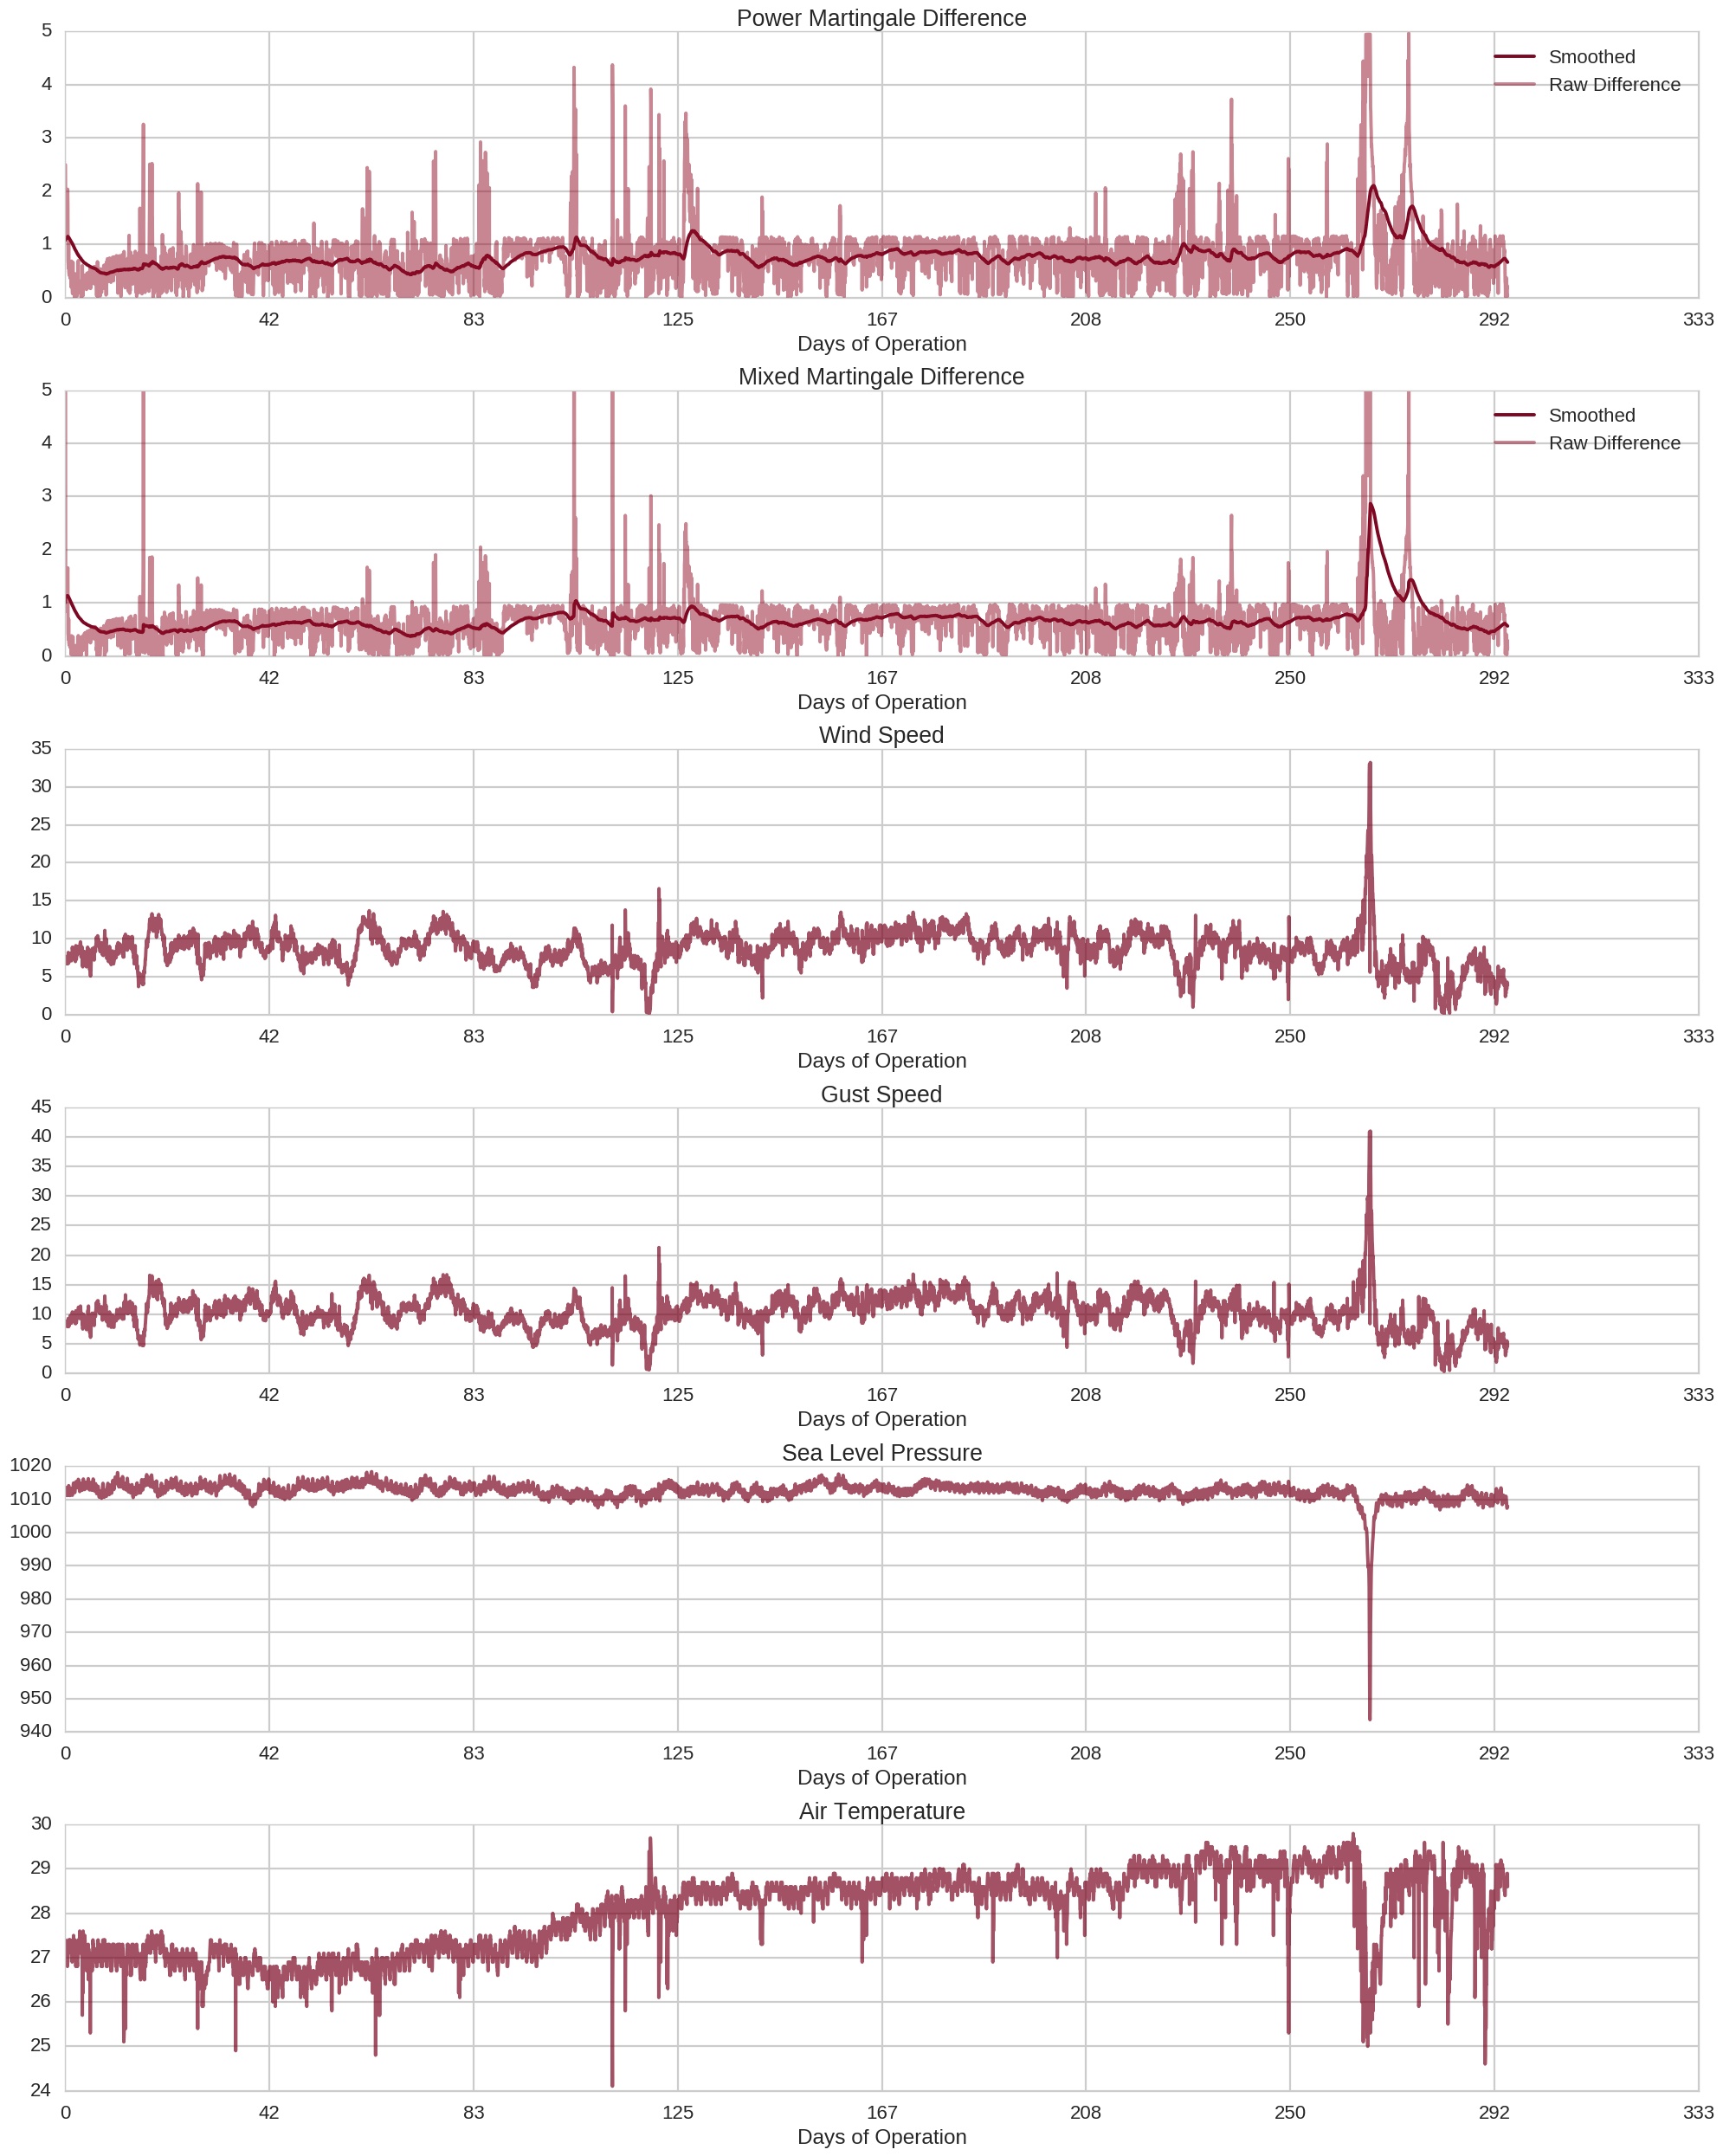

In [34]:
# Visualize change detection for Power martingale
# -----------------------------------------------

fig = plt.figure(figsize = (20,25))

# timeseries
cd_pwr = smooth(diff_pwr , a)[delay:]
cd_mix = smooth(diff_mix , a)[delay:]
data_plot = data_clean[delay:]

# number of subplots
nsp = data_plot.shape[1]

# Power martingale
ax1 = fig.add_subplot(nsp+2 , 1 , 1)
ax1.plot(cd_pwr , label = 'Smoothed')
ax1.plot(diff_pwr[delay:] , alpha = 0.5 , label = 'Raw Difference')
ax1.set_title('Power Martingale Difference')
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax1.set_xlabel('Days of Operation')
ax1.legend()

# Mix martingale
ax2 = fig.add_subplot(nsp+2 , 1 , 2)
ax2.plot(cd_mix , label = 'Smoothed')
ax2.plot(diff_mix[delay:] , alpha = 0.5 , label = 'Raw Difference')
ax2.set_title('Mixed Martingale Difference')
ax2.set_ylim([0,5])
ax2.legend()
vals = ax2.get_xticks()
ax2.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax2.set_xlabel('Days of Operation')

for i in range(nsp):
    ax = fig.add_subplot(nsp + 2, 1, i + 3)
    ax.plot(data_plot[:,i], alpha = 0.7)
    ax.set_title(get_name(title[i]))
    vals = ax.get_xticks()
    ax.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
    ax.set_xlabel('Days of Operation')
    
plt.tight_layout()
plt.show()

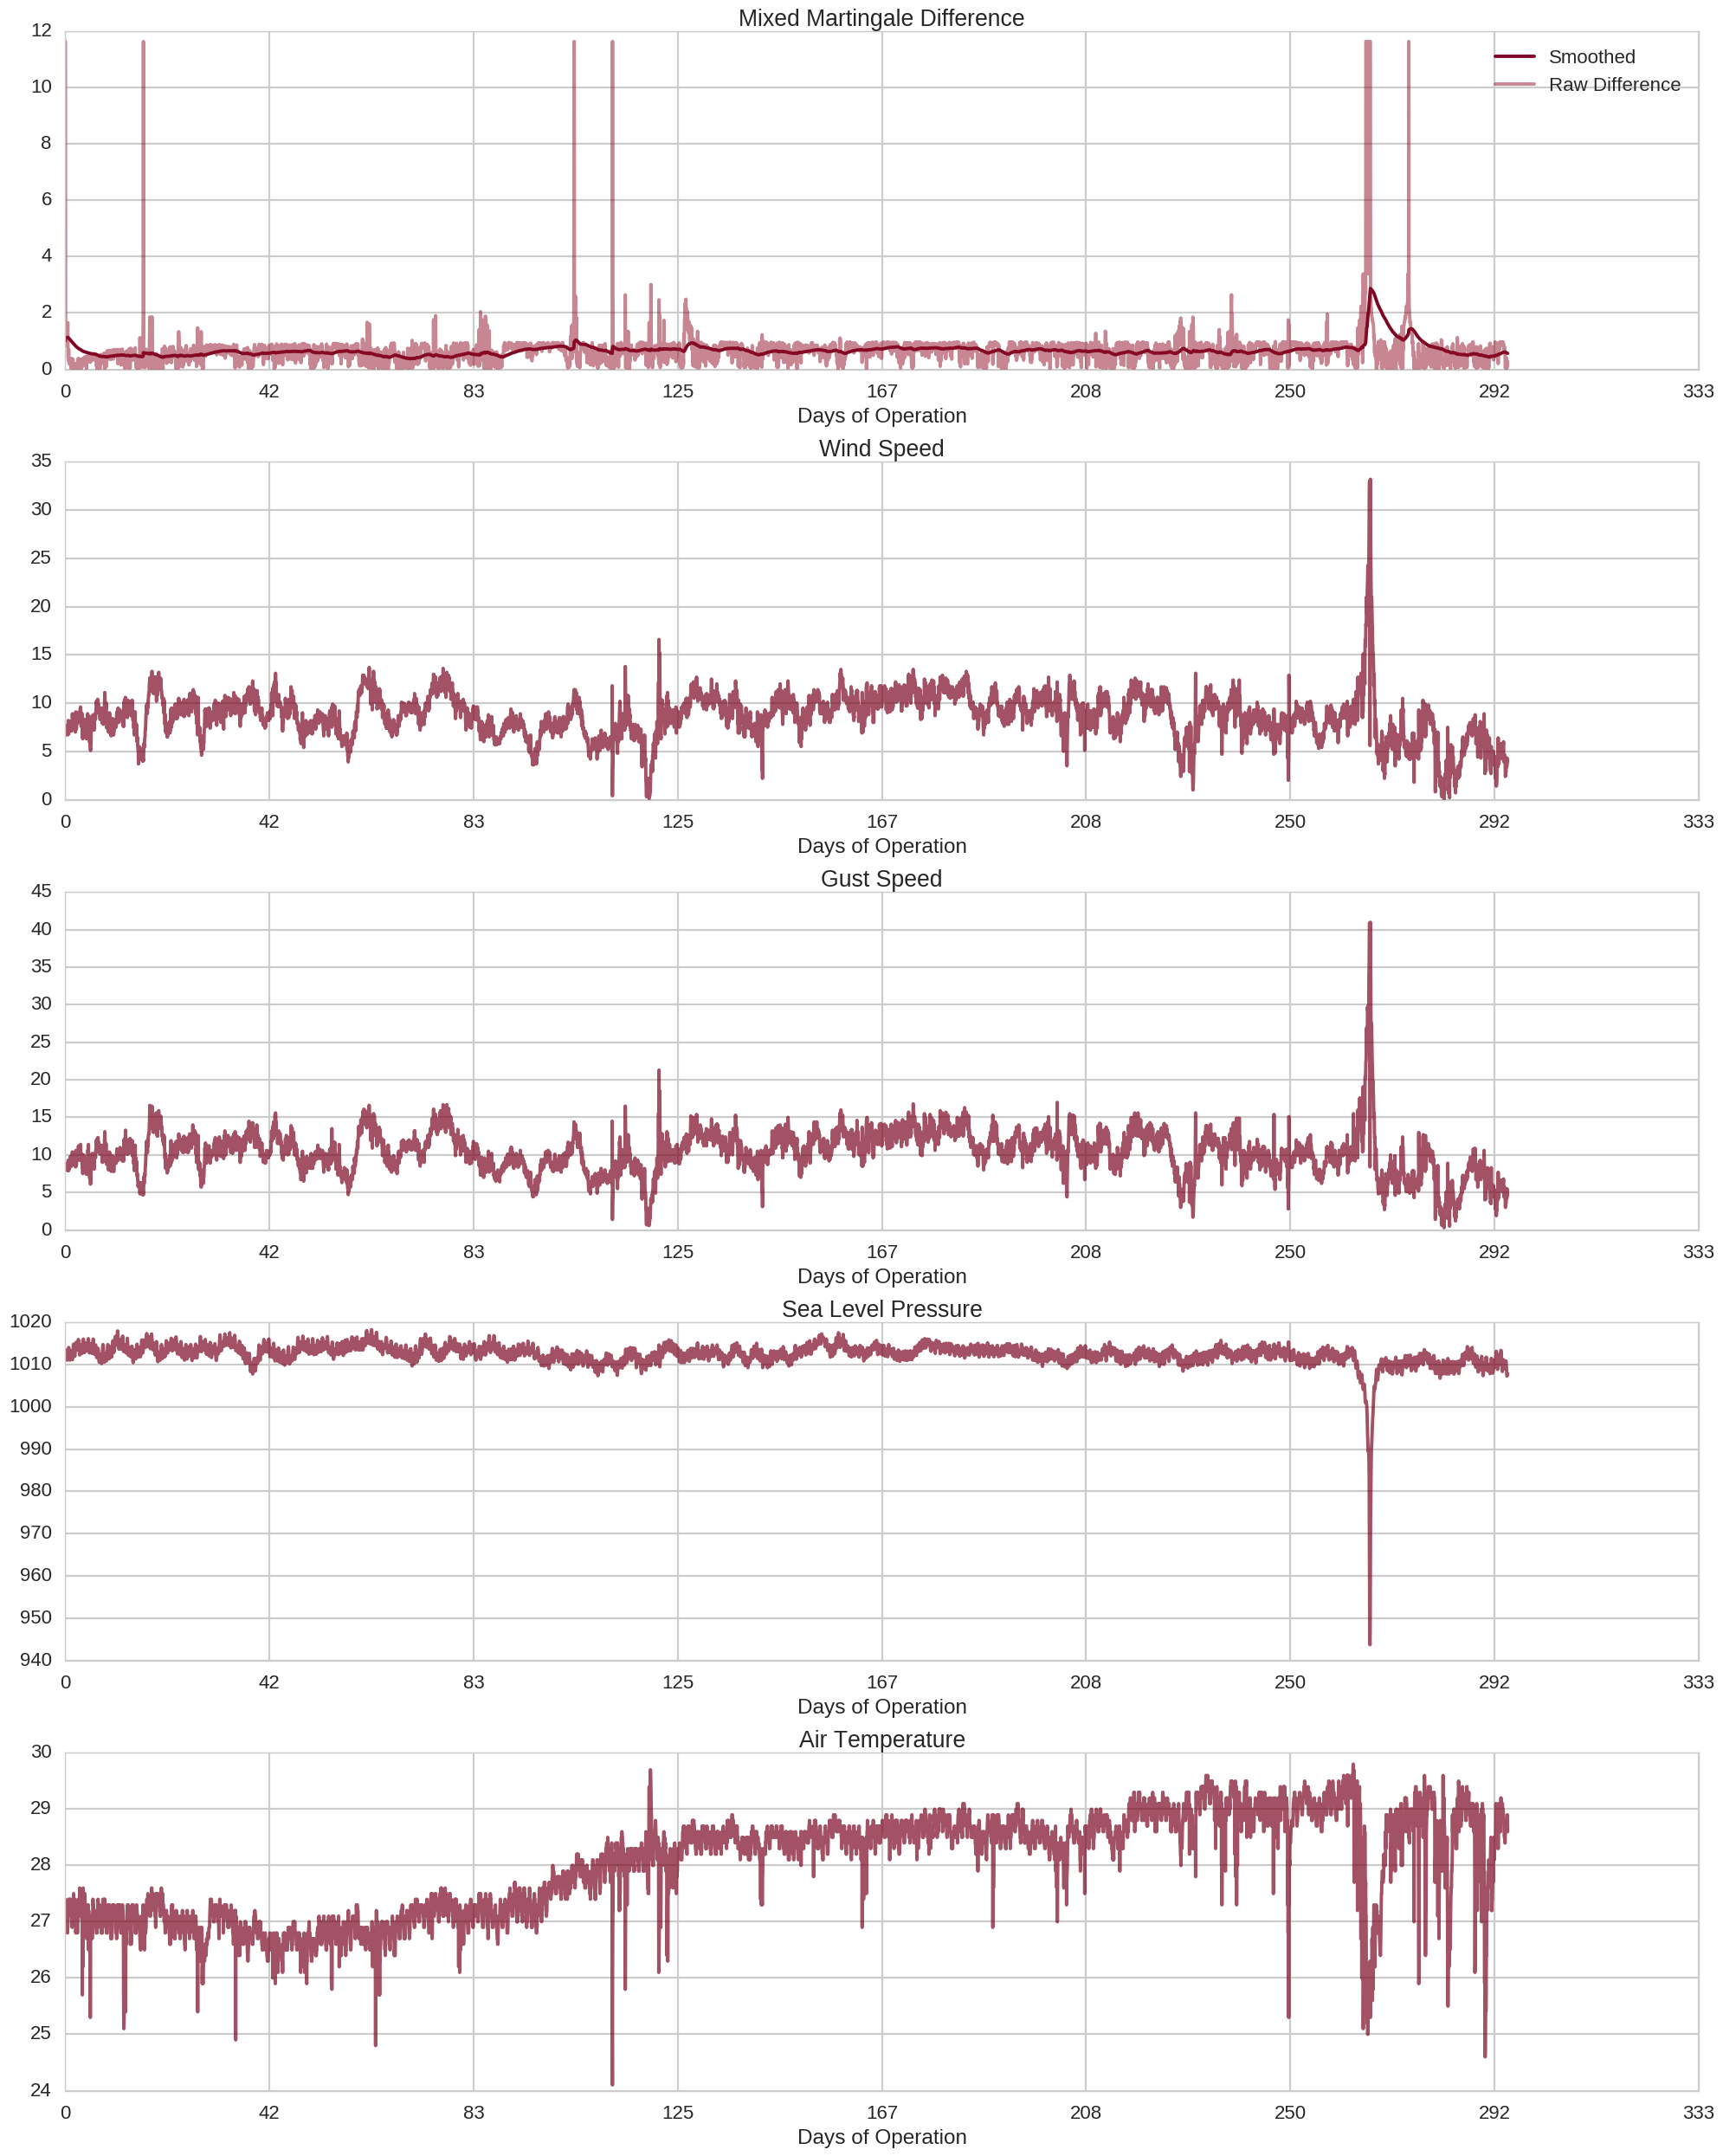

In [37]:
# Visualize change detection for Power martingale
# -----------------------------------------------

fig = plt.figure(figsize = (20,25))

# Mixed Martingale
ax1 = fig.add_subplot(nsp+1 , 1 , 1)
ax1.plot(cd_mix , label = 'Smoothed')
ax1.plot(diff_mix[delay:] , alpha = 0.5 , label = 'Raw Difference')
ax1.set_title('Mixed Martingale Difference')
ax1.legend()
vals = ax1.get_xticks()
ax1.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax1.set_xlabel('Days of Operation')

for i in range(nsp):
    ax = fig.add_subplot(nsp + 1, 1, i + 2)
    ax.plot(data_plot[:,i] , alpha = 0.7)
    ax.set_title(get_name(title[i]))
    vals = ax.get_xticks()
    ax.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
    ax.set_xlabel('Days of Operation')
plt.tight_layout()
plt.show()

In [38]:
# Dual heatmap array
# ------------------
    
# apply smoothing
xk1 = smooth(diff_pwr , a)
xk2 = smooth(diff_mix , a)
    
# reshape arrays
x1 = xk1.reshape((1,L)) 
x2 = xk2.reshape((1,L)) 
    
# Augment arrays
ext1 = np.concatenate((x1 , x1) , axis = 0)
ext2 = np.concatenate((x2 , x2) , axis = 0)
    
# Join arrays
ext = np.concatenate((ext1 , ext2) , axis = 0)

        

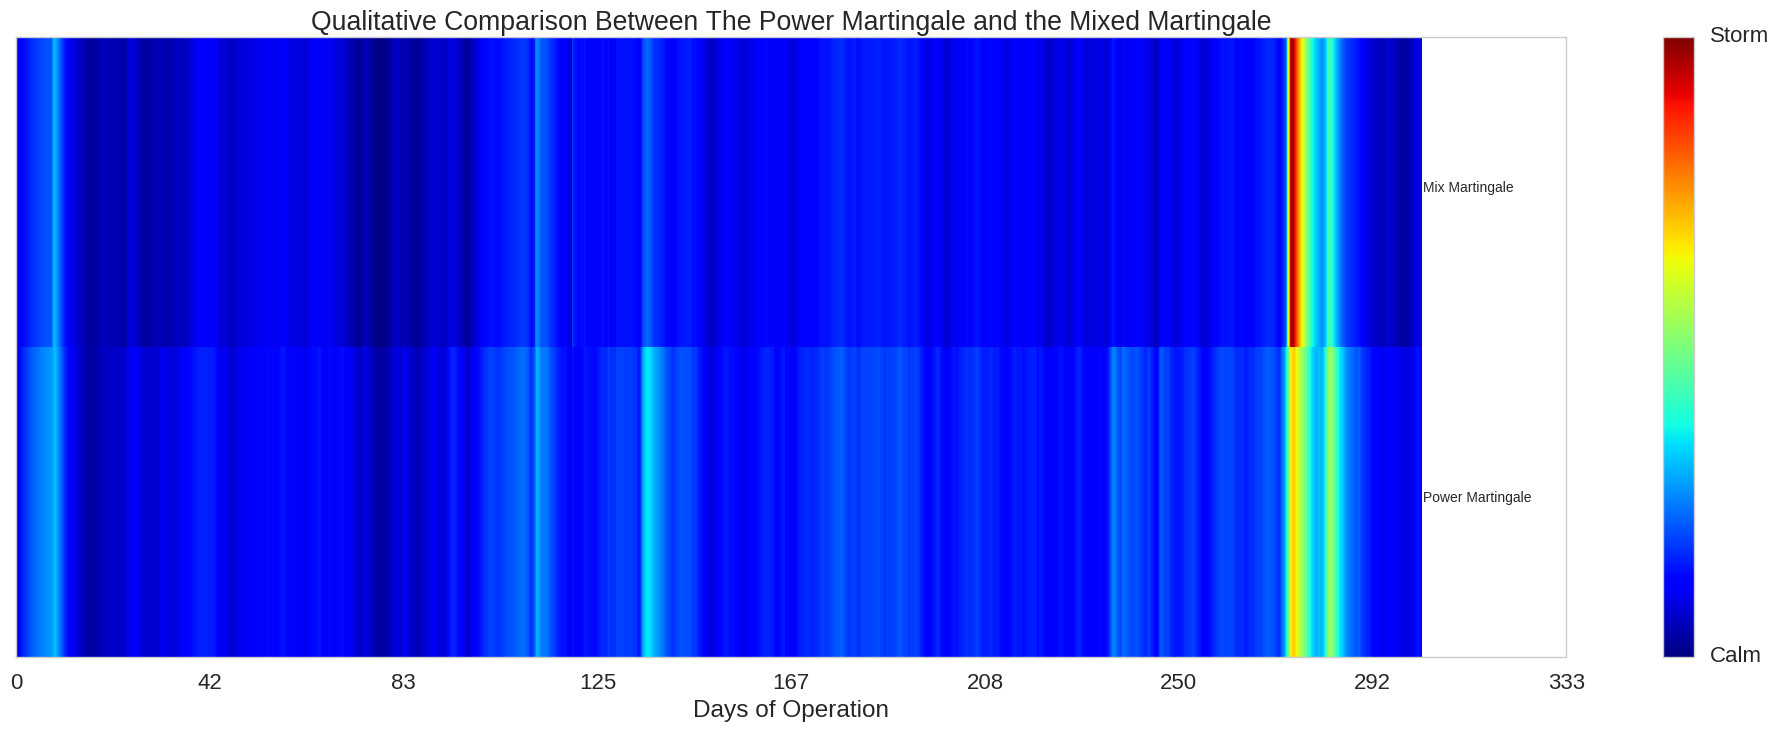

In [40]:
# visualize the heatmaps:
# -----------------------

fig = plt.figure(figsize = (25,8))

#
ax = fig.add_subplot(1,1,1)
cax = ax.pcolor(ext , cmap = clr)
mn = np.min(ext)
mx = np.max(ext)
cbar = fig.colorbar(cax , ticks = [mn ,mx])
cbar.ax.set_yticklabels(['Calm' , 'Storm'])
ax.text(L + 5,1,'Power Martingale')
ax.text(L + 5,3,'Mix Martingale')
ax.set_title('Qualitative Comparison Between The Power Martingale and the Mixed Martingale')
ax.set_xlabel('Time (Jan 2016 - Oct 2016)')
ax.axes.get_yaxis().set_visible(False)
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0f}'.format(x/24) for x in vals])
ax.set_xlabel('Days of Operation')

plt.show()

---